In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import random
from graphviz import Digraph

# Building the blocks for a MLP (Multi Layer Perceptron) Neural Network

In [3]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _prev=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_prev)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value({self.label}={self.data}, grad={self.grad})"

In [4]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [5]:
a = Value(3, label='a')
a

Value(a=3, grad=0)

In [6]:
x = Value(3, label='x')
w = Value(-2, label='w')

wx = w*x; wx.label='wx'
b = Value(4, label='b')
wxb = wx+b; wxb.label='wx+b'
y = wxb.tanh(); y.label='y'
y

Value(y=-0.9640275800758168, grad=0)

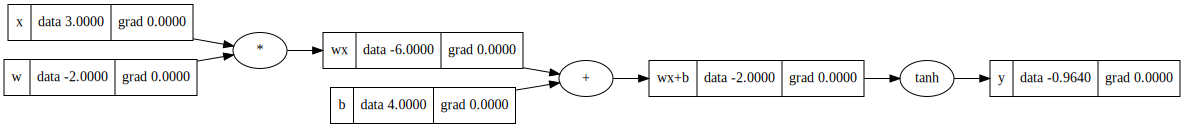

In [7]:
draw_dot(y)

In [8]:
y.backward()

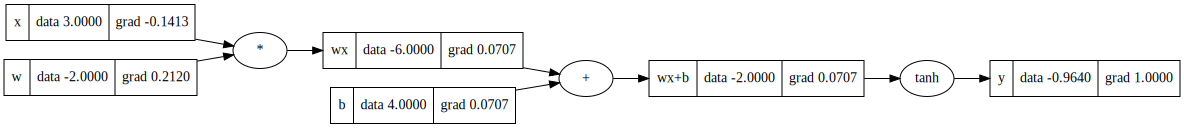

In [9]:
draw_dot(y)

In [10]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1), label='w') for _ in range(nin)]
        self.b = Value(random.uniform(-1,1), label='b')

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)))
        act += self.b
        act.label = 'act'
        out = act.tanh()
        out.label = 'out'
        return out

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"Neuron({len(self.w)})"

In [11]:
x = [2, 3]
f = Neuron(2)
y = f(x)
y

Value(out=-0.9991416794669938, grad=0)

In [12]:
f.parameters()

[Value(w=-0.9122017026146652, grad=0),
 Value(w=-0.9150460862995036, grad=0),
 Value(b=0.6929162267147893, grad=0)]

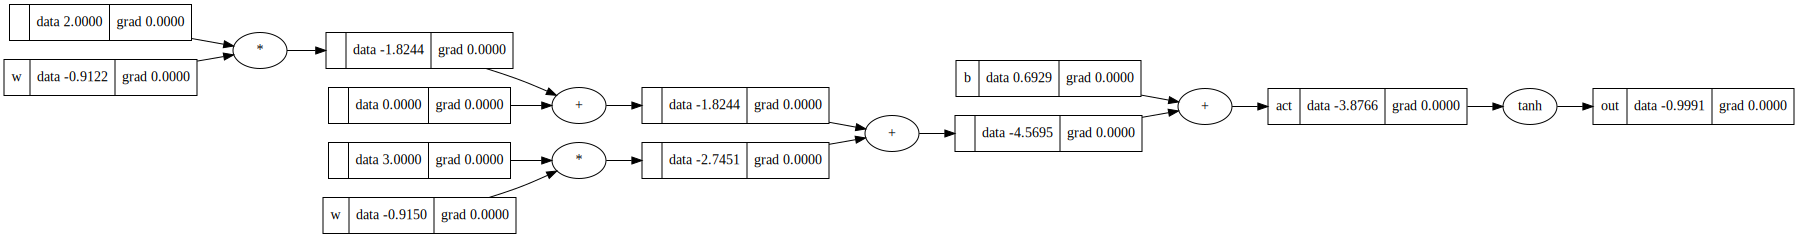

In [13]:
draw_dot(y)

In [14]:
class ValueList:
    def __init__(self, values):
        self.values = values

    def backward(self):
        for v in self.values:
            v.backward()

    def __getitem__(self, i):
        return self.values[i]

    def __iter__(self):
        return iter(self.values)

    def __repr__(self):
        return f"ValueList({self.values})"

class Layer(Module):
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else ValueList(outs)

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

In [15]:
l = Layer(3, 4)
x = [2, 3 ,-1]

In [16]:
l

Layer of [Neuron(3), Neuron(3), Neuron(3), Neuron(3)]

In [17]:
l.parameters()

[Value(w=-0.9708350001804233, grad=0),
 Value(w=0.6540874160753445, grad=0),
 Value(w=-0.4416421971062039, grad=0),
 Value(b=-0.9777498602855303, grad=0),
 Value(w=-0.7072010264734907, grad=0),
 Value(w=-0.24641570898781517, grad=0),
 Value(w=0.03835160202318488, grad=0),
 Value(b=-0.7596700184547824, grad=0),
 Value(w=-0.4399456351418414, grad=0),
 Value(w=0.7383662528474095, grad=0),
 Value(w=-0.6468968299592166, grad=0),
 Value(b=0.4933563406548942, grad=0),
 Value(w=0.7701545081141674, grad=0),
 Value(w=-0.46498905447442507, grad=0),
 Value(w=0.6623980384095591, grad=0),
 Value(b=-0.15479738757527062, grad=0)]

In [18]:
y = l(x)
y

ValueList([Value(out=-0.4742313900788026, grad=0), Value(out=-0.9945542566145771, grad=0), Value(out=0.9859456890265024, grad=0), Value(out=-0.586197838578009, grad=0)])

In [19]:
y[0].backward()

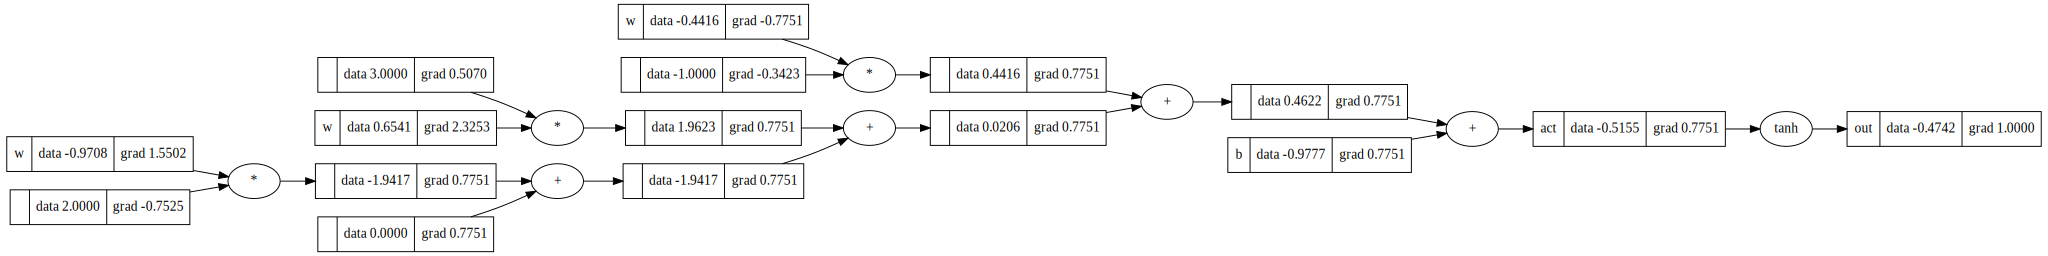

In [20]:
draw_dot(y[0])

In [21]:
y.backward()

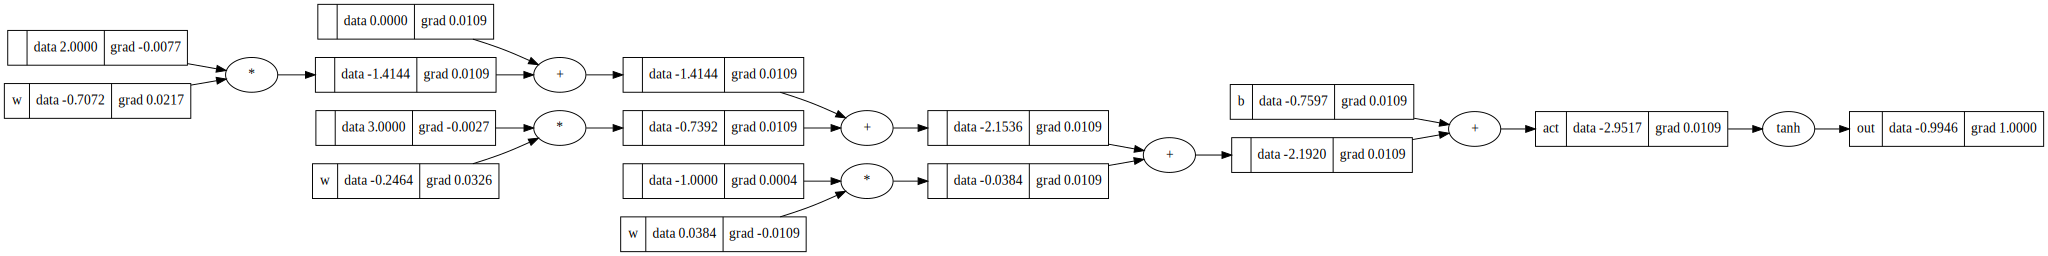

In [22]:
draw_dot(y[1])

In [23]:
class MLP(Module):
    def __init__(self, nin, nouts):
        szs = [nin] + nouts
        self.nin = nin
        self.layers = [Layer(szs[i], szs[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of {self.nin} Inputs and {len(self.layers)} Layers: [{', '.join(str(layer) for layer in self.layers)}]"

    def loss(self, xs, ys):
        ypred = [self(x) for x in xs]
        loss = sum((ygt-ypred)**2 for ygt, ypred in zip(ys, ypred))
        return loss

In [24]:
x = [3, -4, 2]
ops = [4, 4, 1]

mlp = MLP(3, ops)

In [25]:
mlp

MLP of 3 Inputs and 3 Layers: [Layer of [Neuron(3), Neuron(3), Neuron(3), Neuron(3)], Layer of [Neuron(4), Neuron(4), Neuron(4), Neuron(4)], Layer of [Neuron(4)]]

In [26]:
op = mlp(x)
op

Value(out=-0.21392411246697693, grad=0)

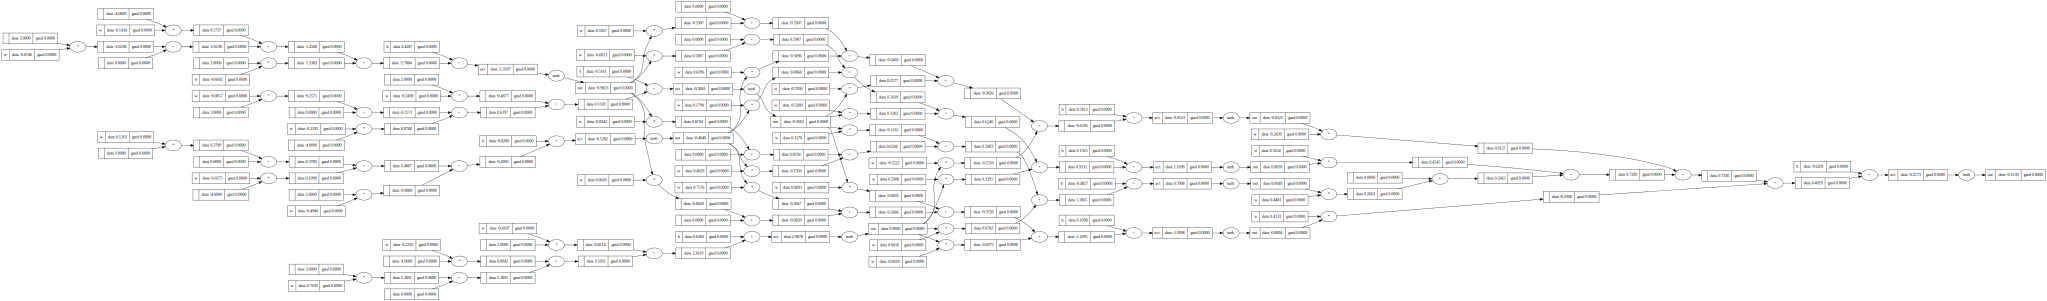

In [27]:
draw_dot(op)

In [28]:
mlp2 = MLP(3, [4, 4, 2])
op2 = mlp2(x)
op2

ValueList([Value(out=0.3733012278150391, grad=0), Value(out=0.7453905559961712, grad=0)])

In [29]:
op2[0].backward()
op.backward()

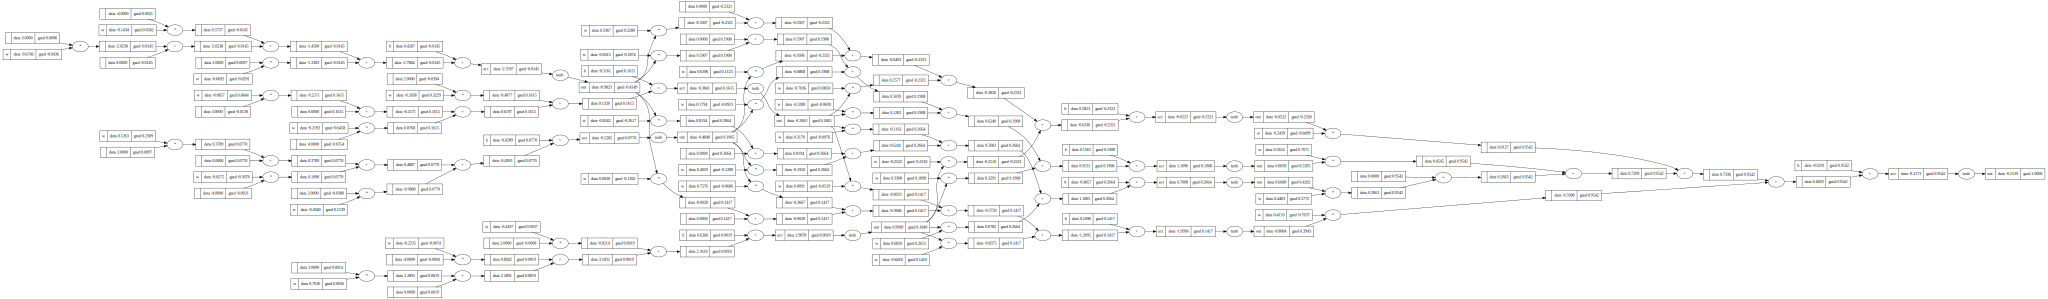

In [30]:
draw_dot(op)

In [31]:
op2.backward()

# the class ValueList enables us to run backward directly on a list (runs on individual elements in background)

# Loss function with an example dataset

In [32]:
xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, -1],
    [1, 1, -1]
]

ys = [1, -1, -1, 1] # desired outputs

In [33]:
n = MLP(3, [4, 4, 1])

ypred = [n(x) for x in xs]
ypred

[Value(out=0.004299788968088232, grad=0),
 Value(out=-0.043090756843212216, grad=0),
 Value(out=-0.2505848890348286, grad=0),
 Value(out=-0.06647992873821808, grad=0)]

In [34]:
# mean square error loss
loss = sum((ygt-ypred)**2 for ygt, ypred in zip(ys, ypred))
loss

Value(=3.606096656832305, grad=0)

In [35]:
n.loss(xs, ys)

Value(=3.606096656832305, grad=0)

In [36]:
# Now we want to minimize the loss function, at any cost, this will get us closer to ys
loss.backward()

In [37]:
n.layers[0].neurons[0].w

[Value(w=-0.8545589253503036, grad=0.9503788772660219),
 Value(w=0.29462914107941063, grad=1.055258858914164),
 Value(w=0.2880371498175549, grad=-0.37622376686507486)]

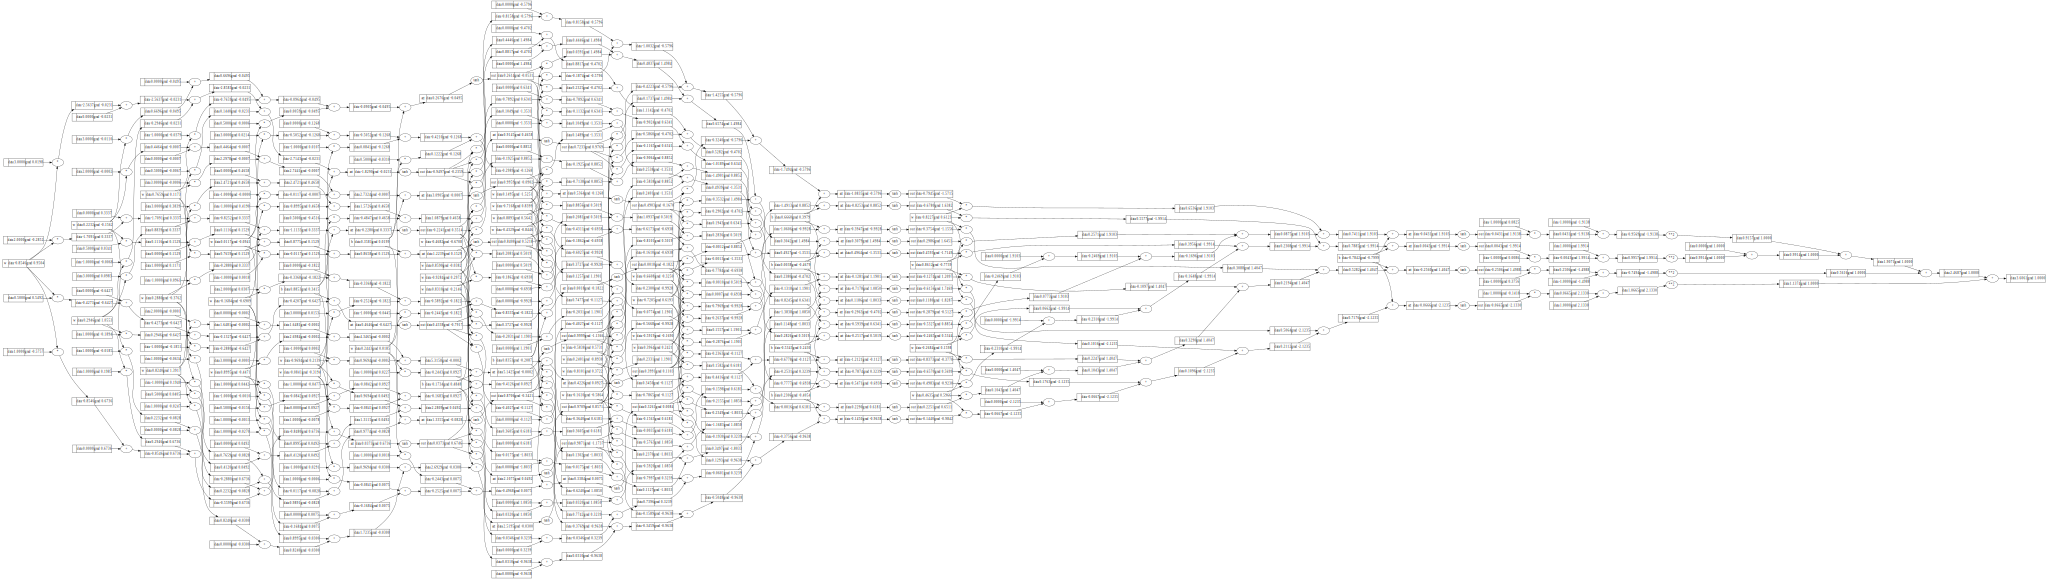

In [38]:
draw_dot(loss)

In [39]:
n.parameters()

[Value(w=-0.8545589253503036, grad=0.9503788772660219),
 Value(w=0.29462914107941063, grad=1.055258858914164),
 Value(w=0.2880371498175549, grad=-0.37622376686507486),
 Value(b=0.8852816466557529, grad=0.34153547146681124),
 Value(w=0.2231840616179095, grad=-0.1562400643056412),
 Value(w=0.7659168721295115, grad=0.11734655779921968),
 Value(w=0.011729653685238706, grad=-0.09409934600905437),
 Value(b=0.35810990267032805, grad=0.019899496679855216),
 Value(w=0.8240257946925096, grad=1.3917346347158566),
 Value(w=0.8994788454371963, grad=-0.4471416287927576),
 Value(w=-0.9693607772133483, grad=0.21391698402963855),
 Value(b=-0.17337761018131825, grad=0.4848256139861226),
 Value(w=-0.16839298032955297, grad=-0.6909130449576494),
 Value(w=-0.084146033567704, grad=-0.3194097127643728),
 Value(w=0.2443028457213079, grad=0.01848877186014241),
 Value(b=0.8352794919147875, grad=-0.2087307226878087),
 Value(w=0.8310093796970206, grad=-0.21456891859084007),
 Value(w=-0.4328916037289905, grad=-0.8

---

Now we have the grad of loss wrt each parameter (weight, bias)

For parameters with -ve grad, we can reduce the value to make loss higher
For parameters with _ve grad, increasing value with make loss higher

So going in the sign of grad will make the op(loss) higher, going against the sign of grad will make the op(loss) lower

---

In [40]:
# let's nudge the parameters to reduce loss (nudge a/c to the sign of grad)
for p in n.parameters():
    p.data += (-0.01*p.grad) # step size = 0.01
    # going aginst the grad (-ve sign) to reduce the loss

In [41]:
loss = n.loss(xs, ys)
loss

Value(=3.4751663289319374, grad=0)

In [42]:
loss.backward()

In [43]:
for p in n.parameters():
    p.data += (-0.01*p.grad)

In [44]:
loss = n.loss(xs, ys)
loss

Value(=3.2958344953121887, grad=0)

In [45]:
# forward pass
loss = n.loss(xs, ys)
print("Initial Loss: ", loss)

# backward pass
loss.backward()

# nudge
for p in n.parameters():
    p.data += (-0.01*p.grad)

loss = n.loss(xs, ys)
print("Final Loss: ", loss)

Initial Loss:  Value(=3.2958344953121887, grad=0)
Final Loss:  Value(=3.061705204458494, grad=0)


This is **Gradient Descent**, we are iteratively doing forward pass, backward pass then nudging the weights and bias a/c to gradient. Until we reach minimum loss

In [46]:
class MLP(Module):
    def __init__(self, nin, nouts):
        szs = [nin] + nouts
        self.nin = nin
        self.layers = [Layer(szs[i], szs[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of {self.nin} Inputs and {len(self.layers)} Layers: [{', '.join(str(layer) for layer in self.layers)}]"

    def loss(self, xs, ys):
        ypred = [self(x) for x in xs]
        loss = sum((Value(ygt)-ypred)**2 for ygt, ypred in zip(ys, ypred))
        return loss

    def grad_desc(self, xs, ys, step_size=0.01, iter=1):
        for k in range(iter):
            loss = self.loss(xs, ys)
            self.zero_grad() #reset grad to 0 for all parameters
            loss.backward() #calculate new grads

            for p in self.parameters():
                p.data += (-1.0 * step_size * p.grad)
            loss = self.loss(xs, ys)
            print("Loss: ", loss.data)

In [47]:
xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, -1],
    [1, 1, -1]
]

ys = [1, -1, -1, 1] # desired outputs

In [48]:
n = MLP(3, [4, 4, 1])

ypred = [n(x) for x in xs]
ypred

[Value(out=0.28859710130213023, grad=0),
 Value(out=-0.41981465249141864, grad=0),
 Value(out=-0.4696291192942528, grad=0),
 Value(out=-0.6770020719254671, grad=0)]

In [49]:
n.loss(xs, ys)

Value(=3.9363383420822853, grad=0)

In [50]:
n.grad_desc(xs, ys, 0.05)

Loss:  2.863166164369218


In [51]:
ypred = [n(x) for x in xs]
ypred

[Value(out=0.6698491373986241, grad=0),
 Value(out=-0.4344410439269207, grad=0),
 Value(out=-0.0021509368282134774, grad=0),
 Value(out=-0.1994193956350305, grad=0)]

In [52]:
n.grad_desc(xs, ys)

Loss:  2.7569770400910256


In [53]:
ypred = [n(x) for x in xs]
ypred

[Value(out=0.6853799542394351, grad=0),
 Value(out=-0.4604173344358522, grad=0),
 Value(out=0.026285368617537438, grad=0),
 Value(out=-0.14611524554946043, grad=0)]

In [54]:
n.grad_desc(xs, ys)

ypred = [n(x) for x in xs]
ypred

Loss:  2.662621945183038


[Value(out=0.6983925561798809, grad=0),
 Value(out=-0.4849310957900493, grad=0),
 Value(out=0.04816903431554892, grad=0),
 Value(out=-0.09895431862898756, grad=0)]

In [55]:
n.grad_desc(xs, ys)

ypred = [n(x) for x in xs]
ypred

Loss:  2.5787011073215647


[Value(out=0.7092987314516073, grad=0),
 Value(out=-0.5080276901015858, grad=0),
 Value(out=0.06327088776224302, grad=0),
 Value(out=-0.059061917602757814, grad=0)]

In [56]:
n.grad_desc(xs, ys, 0.0001)

ypred = [n(x) for x in xs]
ypred

Loss:  2.577928108466237


[Value(out=0.7093933016721455, grad=0),
 Value(out=-0.50824545617045, grad=0),
 Value(out=0.06335237999297902, grad=0),
 Value(out=-0.05874219710913507, grad=0)]

In [57]:
for k in range(20):
    n.grad_desc(xs, ys, 0.05)

Loss:  2.249427750859331
Loss:  2.000976288951034
Loss:  1.7948149852787854
Loss:  1.6422148349807162
Loss:  1.7219749825472737
Loss:  2.209774561316906
Loss:  2.3367692055428546
Loss:  1.780792022388937
Loss:  2.2810505701033343
Loss:  1.5036923039255867
Loss:  2.050617033918547
Loss:  1.5954301684832832
Loss:  2.0395149996627455
Loss:  1.4910005220473084
Loss:  1.905144109829116
Loss:  1.5069426110461146
Loss:  1.8248553197954707
Loss:  1.4913615926867974
Loss:  1.7310644973475655
Loss:  1.4791262332818709


In [58]:
# Loss is getting plateud again, let's use a smaller rate
for k in range(200):
    n.grad_desc(xs, ys, 0.01)

Loss:  0.8334012161798399
Loss:  0.595451029498441
Loss:  0.5250698558943324
Loss:  0.49716868074885023
Loss:  0.48107714652350353
Loss:  0.4686737550028153
Loss:  0.4576226819928776
Loss:  0.44721911714041573
Loss:  0.43724005313948955
Loss:  0.4276083088351222
Loss:  0.4182916377945668
Loss:  0.40927199410213
Loss:  0.40053608023136633
Loss:  0.39207241199001985
Loss:  0.383870392058406
Loss:  0.37592000605878706
Loss:  0.3682117128850241
Loss:  0.36073639639198085
Loss:  0.35348533702293883
Loss:  0.34645019039257025
Loss:  0.339622968716071
Loss:  0.3329960237537072
Loss:  0.3265620308142928
Loss:  0.32031397363850744
Loss:  0.3142451300728596
Loss:  0.3083490584758196
Loss:  0.3026195848096319
Loss:  0.29705079037717386
Loss:  0.2916370001670163
Loss:  0.2863727717727531
Loss:  0.2812528848551616
Loss:  0.276272331117949
Loss:  0.2714263047698013
Loss:  0.2667101934472136
Loss:  0.2621195695741872
Loss:  0.25765018213632507
Loss:  0.253297948848183
Loss:  0.24905894869395942
Loss:

In [59]:
# Leave it, the o/ps are good enough now

ypred = [n(x) for x in xs]
ypred

[Value(out=0.9749698593270366, grad=0),
 Value(out=-0.93206453341691, grad=0),
 Value(out=-0.8507002847310274, grad=0),
 Value(out=0.8452832649865273, grad=0)]

In [60]:
# Somehow , the values converged completely

n.parameters()

[Value(w=-1.750082250928804, grad=0.05383302149285296),
 Value(w=0.07068720459942517, grad=-0.010413943165796358),
 Value(w=-0.5901395873090044, grad=0.010473215272133934),
 Value(b=0.5618068451395911, grad=-0.010479975306289413),
 Value(w=0.4730864085570258, grad=0.00698879124336077),
 Value(w=1.1993450744346188, grad=-0.010364024065094964),
 Value(w=0.4879932079057879, grad=0.003641342411370138),
 Value(b=-0.8071660930348559, grad=0.016544880650845736),
 Value(w=-0.37253432871817554, grad=-0.0038750337280391636),
 Value(w=-0.9207143590166861, grad=0.006021706963319377),
 Value(w=-0.4635776416613513, grad=-0.0013432429031139392),
 Value(b=0.3042494911079428, grad=-0.01267766589589258),
 Value(w=-0.32131668765648785, grad=0.00597398283858043),
 Value(w=-1.081900273234867, grad=-1.240437876445788e-05),
 Value(w=0.07319272003512801, grad=0.006480211822305834),
 Value(b=0.790548630647065, grad=-0.025838318646620048),
 Value(w=0.4722753735283998, grad=-0.03616191066638942),
 Value(w=0.3889

In [61]:
n.grad_desc(xs, ys, 0.0001, 100)

Loss:  0.05146639036570331
Loss:  0.051463372406591525
Loss:  0.05146035475721571
Loss:  0.05145733741753149
Loss:  0.05145432038749444
Loss:  0.0514513036670599
Loss:  0.05144828725618318
Loss:  0.051445271154820185
Loss:  0.051442255362926126
Loss:  0.05143923988045686
Loss:  0.0514362247073676
Loss:  0.05143320984361406
Loss:  0.051430195289151714
Loss:  0.051427181043936024
Loss:  0.05142416710792304
Loss:  0.05142115348106763
Loss:  0.05141814016332567
Loss:  0.05141512715465296
Loss:  0.051412114455004904
Loss:  0.051409102064337193
Loss:  0.05140608998260536
Loss:  0.05140307820976497
Loss:  0.051400066745771744
Loss:  0.05139705559058137
Loss:  0.051394044744149436
Loss:  0.051391034206431395
Loss:  0.05138802397738336
Loss:  0.051385014056960596
Loss:  0.05138200444511899
Loss:  0.05137899514181411
Loss:  0.05137598614700182
Loss:  0.051372977460637737
Loss:  0.05136996908267742
Loss:  0.05136696101307675
Loss:  0.05136395325179151
Loss:  0.05136094579877725
Loss:  0.051357938

In [62]:
n.grad_desc(xs, ys, 0.001, 100)

Loss:  0.05113923976110789
Loss:  0.051109402046150595
Loss:  0.05107959480182152
Loss:  0.05104981798454024
Loss:  0.05102007155080586
Loss:  0.05099035545719667
Loss:  0.05096066966037008
Loss:  0.050931014117061774
Loss:  0.05090138878408683
Loss:  0.05087179361833849
Loss:  0.05084222857678837
Loss:  0.05081269361648596
Loss:  0.05078318869455895
Loss:  0.050753713768213145
Loss:  0.05072426879473114
Loss:  0.05069485373147393
Loss:  0.05066546853587925
Loss:  0.05063611316546211
Loss:  0.05060678757781434
Loss:  0.050577491730604704
Loss:  0.05054822558157867
Loss:  0.05051898908855779
Loss:  0.05048978220944039
Loss:  0.0504606049022005
Loss:  0.05043145712488843
Loss:  0.050402338835629834
Loss:  0.0503732499926266
Loss:  0.05034419055415541
Loss:  0.05031516047856868
Loss:  0.05028615972429404
Loss:  0.05025718824983358
Loss:  0.05022824601376467
Loss:  0.05019933297473912
Loss:  0.05017044909148315
Loss:  0.050141594322797314
Loss:  0.05011276862755669
Loss:  0.050083971964709

In [63]:
n.grad_desc(xs, ys, 0.005, 100)

Loss:  0.048191599235812246
Loss:  0.04805728906642309
Loss:  0.047923635165789596
Loss:  0.04779063304010554
Loss:  0.04765827823475
Loss:  0.047526566333876
Loss:  0.04739549296000245
Loss:  0.047265053773612196
Loss:  0.04713524447275464
Loss:  0.047006060792653154
Loss:  0.046877498505317514
Loss:  0.04674955341916055
Loss:  0.04662222137862
Loss:  0.04649549826378495
Loss:  0.04636937999002595
Loss:  0.046243862507630726
Loss:  0.04611894180144389
Loss:  0.04599461389050995
Loss:  0.04587087482772301
Loss:  0.0457477206994778
Loss:  0.045625147625327135
Loss:  0.04550315175764204
Loss:  0.04538172928127708
Loss:  0.04526087641323869
Loss:  0.0451405894023581
Loss:  0.045020864528967544
Loss:  0.04490169810458121
Loss:  0.04478308647157895
Loss:  0.04466502600289464
Loss:  0.04454751310170724
Loss:  0.04443054420113666
Loss:  0.044314115763941855
Loss:  0.044198224282224266
Loss:  0.044082866277132135
Loss:  0.043968038298571474
Loss:  0.04385373692491738
Loss:  0.04373995876273086

In [73]:
n.grad_desc(xs, ys, 0.01, 200)

Loss:  0.0035027915388244884
Loss:  0.0035005862411248674
Loss:  0.003498383559832013
Loss:  0.003496183490410566
Loss:  0.0034939860283354027
Loss:  0.0034917911690917768
Loss:  0.0034895989081751132
Loss:  0.003487409241091158
Loss:  0.003485222163355765
Loss:  0.0034830376704950757
Loss:  0.0034808557580452678
Loss:  0.003478676421552735
Loss:  0.0034764996565738956
Loss:  0.0034743254586752197
Loss:  0.003472153823433274
Loss:  0.00346998474643457
Loss:  0.003467818223275648
Loss:  0.0034656542495629292
Loss:  0.0034634928209128146
Loss:  0.003461333932951607
Loss:  0.00345917758131543
Loss:  0.003457023761650241
Loss:  0.0034548724696118714
Loss:  0.0034527237008658757
Loss:  0.0034505774510875877
Loss:  0.0034484337159620734
Loss:  0.0034462924911841247
Loss:  0.0034441537724581393
Loss:  0.003442017555498231
Loss:  0.003439883836028094
Loss:  0.0034377526097810513
Loss:  0.003435623872499967
Loss:  0.0034334976199372623
Loss:  0.00343137384785486
Loss:  0.0034292525520241883
Los